In [ ]:
import pandas as pd
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import scipy.stats as stats
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm

B='1970-01-01'
E='2019-08-01'
NORM=True
F=.2

In [271]:
!pwd

/run/media/ishanu/D3/cog_dis/data/SOCDATA


In [2]:
# smoothing function with lowess
def Lsmooth(dframe,frac=.3,COL=None,FILL=None,IGNORE=None):
    if FILL is not None:
        dframe=dframe.interpolate(method=FILL)
    T=dframe.index.values
    dframe=dframe.reset_index(drop=True)
    x=dframe.index.values
    cols=dframe.columns
    Z={}
    if IGNORE is not None:
        cols=[x for x in cols if x not in IGNORE]
    for col in dframe[cols]:
        z=lowess(dframe[col].values, x,frac=frac)
        Z[col]=z[:,1]
    if IGNORE is not None:
        for c in IGNORE:
            Z[c] = dframe[c].values
    zf=pd.DataFrame.from_dict(Z)
    zf.index=T
    return zf

<AxesSubplot:>

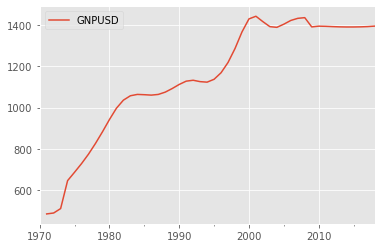

In [3]:
Gnp=pd.read_csv('./data_united-states-gnp-gross-national-product.csv',comment='#',index_col=0,parse_dates=True).dropna(axis=1)
Gnp=Lsmooth(Gnp,frac=.4,COL=None,FILL=None).loc[B:E].diff()
Gnp=pd.DataFrame(Gnp[' US $'])#.plot()
Gnp.columns=['GNPUSD']
Gnp.plot()

<AxesSubplot:>

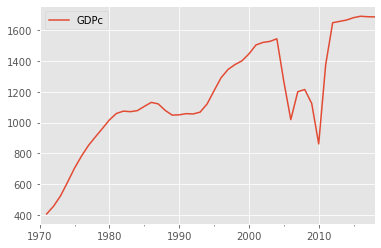

In [4]:
Gdpc=pd.read_csv('./data_united-states-gdp-per-capita.csv',comment='#',index_col=0,parse_dates=True).dropna(axis=1)
Gdpc=Lsmooth(Gdpc,frac=F,COL=None,FILL=None).loc[B:E].diff()
Gdpc
Gdpc.columns=['GDPc']
Gdpc.plot()

<AxesSubplot:>

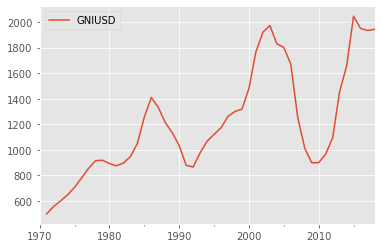

In [5]:
Gni=pd.read_csv('./data_united-states-gni-gross-national-income.csv',comment='#',index_col=0,parse_dates=True).dropna(axis=1)
Gni=Lsmooth(Gni,frac=F,COL=None,FILL=None).loc[B:E].diff()
Gni=pd.DataFrame(Gni[' US $'])#.plot()
Gni.columns=['GNIUSD']
Gni.plot()

<AxesSubplot:>

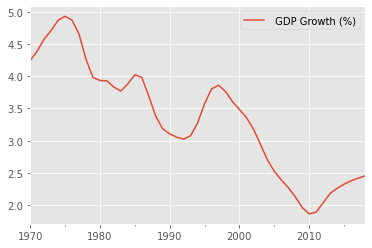

In [6]:
Gf=pd.read_csv('./data_united-states-gdp-growth-rate.csv',comment='#',index_col=0,parse_dates=True).dropna(axis=1)
#Gf.loc[B:E]#.plot()
Lsmooth(Gf,frac=F,COL=None,FILL=None).loc[B:E].plot()

<AxesSubplot:xlabel='date'>

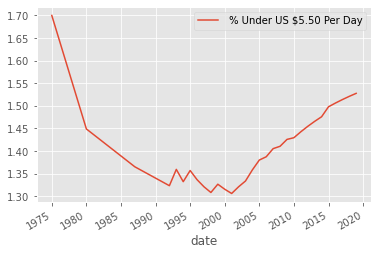

In [7]:
Gf1=pd.read_csv('./data_united-states-poverty-rate.csv',comment='#',index_col=0,parse_dates=True).dropna(axis=1)
GF11=Gf1.loc[B:E].ewm(alpha=.01).mean()
GF11.plot()

<AxesSubplot:xlabel='date'>

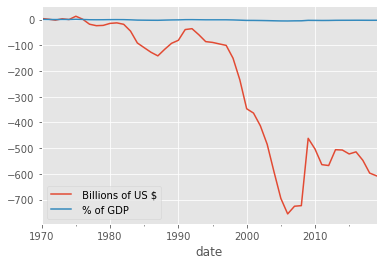

In [8]:
Gf2=pd.read_csv('./data_united-states-trade-balance-deficit.csv',comment='#',index_col=0,parse_dates=True).dropna(axis=1)
Gf2.loc['1970-01-01':].ewm(alpha=.8).mean().plot()
#Gf2=Gf2.loc[B:E].ewm(alpha=.8).mean()

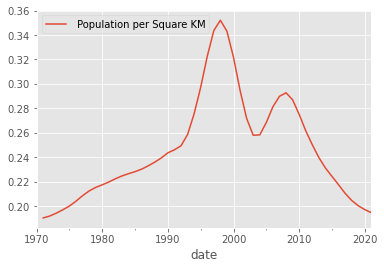

In [9]:
Gf3=pd.read_csv('./data_united-states-population-density-2021-10-07.csv',comment='#',index_col=0,parse_dates=True).dropna(axis=1)
Gf3.loc['1970-01-01':'2022-01-01'].diff().plot()
Gf3=Gf3.loc[B:E].diff()

In [10]:
df=Gf.join(GF11).join(Gf2).join(Gf3).join(Gni).join(Gnp).join(Gdpc)
df=df.interpolate(method='spline',order=2,limit_direction='both')

In [11]:
if NORM:
    df1=df-df.mean()
    df1=df1/df1.std()
else:
    df1=df
COLS=df1.columns
df1=df1.drop(COLS[2],axis=1)
df1=df1.loc[B:E]#.loc['1972-01-01':'2019-01-01']
df1.columns=['GDP','poverty','tradebalance','population','GNIUSD','GNPUSD','GDPcap']


In [12]:
sf=pd.read_csv('SP500.csv',index_col=0,parse_dates=True)
sf=sf.reset_index()
sf=sf.groupby(sf.Date.dt.year).transform('mean').drop_duplicates()
sf=sf.set_index('Date')
sf=sf.loc[B:E]#.loc['1972-01-01':'2019-08-01']
sf.index=df1.index
if NORM:
    sf=sf-sf.mean()
    sf=sf/sf.std()

/home/ishanu/.local/lib/python3.9/site-packages/pandas/core/groupby/generic.py:1404: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  fast_path = lambda group: getattr(group, func)(*args, **kwargs)


<AxesSubplot:xlabel='date'>

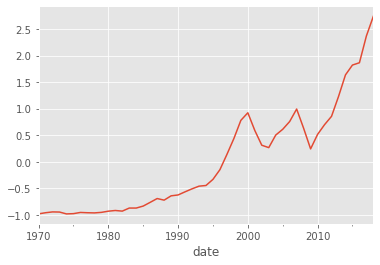

In [13]:
sf.SP500.plot()

In [14]:
df1=df1.assign(sp500=sf.SP500)

In [15]:
cf=pd.read_csv('Congress.csv',comment='#')

cf=cf.assign(Date=cf.Time+2)
cf.Date=pd.to_datetime(cf.Date,format='%Y')
cf=cf.drop('Time',axis=1)#.set_index('Date')
cf.Date=pd.DatetimeIndex(cf.Date) + pd.DateOffset(-1)
cf=cf.set_index('Date')
cf=cf.loc[B:E]
cols=cf.columns
cols=['dem_congress','rep_congress','ind_congress']
cf.columns=cols
cf=cf[cols[:2]]

if NORM:
    cf=cf-cf.mean()
    cf=cf/cf.std()

df1=df1.join(cf).interpolate(method='ffill')

In [16]:
cf=pd.read_csv('Senate.csv',comment='#')
cf['Date']=cf['End Year']
cf=cf[['Date','Percent','Party']]
cf=cf[cf.Party=='Republicans']
cf.Date=pd.to_datetime(cf.Date,format='%Y')
cf.Date=pd.DatetimeIndex(cf.Date) + pd.DateOffset(-1)
cf=cf.set_index('Date')
cf=cf.loc[B:E]

cf=pd.DataFrame(cf['Percent'])
cf.columns=['rep_senate']
if NORM:
    cf=cf-cf.mean()
    cf=cf/cf.std()

df1=df1.join(cf).interpolate(method='ffill')

In [17]:
df1=df1.drop('dem_congress',axis=1)

In [18]:
df1.to_csv('putative_factors_norm.csv')

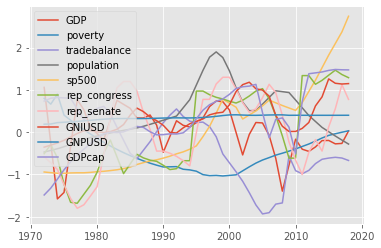

In [19]:
df1=df1.loc['1972-01-01':]
W=Lsmooth(df1,FILL='bfill',frac=.1,IGNORE=['GNIUSD', 'GNPUSD',
       'GDPcap'])
W.index=W.index.year

W.plot()
W.to_csv('putative_factors_smooth.csv')

In [20]:
## generate pole separation across years
#creed2_/GSS/Qnets
import os
import matplotlib.pyplot as plt
import collections
import seaborn as sns 
import pandas as pd
import numpy as np
from cognet.cognet import cognet as cg
from cognet.dataFormatter import dataFormatter
from cognet.model import model 

# get years 
features_by_year = pd.read_csv('../../../cog_dis/cognet/examples/examples_data/features_by_year_GSS.csv',
                               keep_default_na=True, 
                               index_col=False)
POLEFILE='../../../cog_dis/cognet/examples/examples_data/polar_vectors.csv'
qnets_by_year = {x[-11:-7]: x for x in os.listdir('../../qnets/')}
data_by_year = {x[4:8]: x for x in os.listdir('../../data/processed_data')}
polarDist_by_year = {}

In [21]:
for year, qnet in tqdm(qnets_by_year.items()):
    qnet = '../../qnets/' + qnet
    data_obj=dataFormatter('../../data/processed_data/'+data_by_year[year])
    model_obj = model()
    model_obj.load(qnet)
    cognet_obj = cg()
    cognet_obj.load_from_model(model_obj, data_obj, 'all')

    # produce stats on how many column names actually match
    stats = cognet_obj.set_poles(POLEFILE,"R","L",steps=0)

    # compute polar distance matrix
    dmatrix = cognet_obj.polar_separation(nsteps=20)
    polarDist_by_year[year]=dmatrix[0][1]

100%|██████████| 32/32 [03:30<00:00,  6.57s/it]


In [22]:
sorted_dist = collections.OrderedDict(sorted(polarDist_by_year.items()))
df = pd.DataFrame.from_dict(sorted_dist, orient='index')
df.reset_index(level=0, inplace=True)
df.columns = ['year', 'LR']
df.LR=df.LR-df.LR.mean()
df.LR=df.LR/df.LR.std()

In [23]:
LR=Lsmooth(df.set_index('year',drop=True),frac=.15)#.plot()
LR.index=LR.index.astype(int)
W1=W.join(LR).interpolate(method='spline',order=2)

In [24]:
W1.to_csv('integrated_data_smooth.csv')

In [229]:
Wc=W1.corr()
def style_negative(v, props=''):
    return props if v < 0 else None
def style_positive(v, props=''):
    return props if v > 0 else None
s2 = Wc.style.applymap(style_negative, props='color:red;')\
                .applymap(style_positive, props='color:green;')\
              .applymap(lambda v: 'opacity: 40%;' if (v < 0) and (v > -0.6) else None)\
              .applymap(lambda v: 'opacity: 40%;' if (v > 0) and (v < 0.6) else None)
s2

,GDP,poverty,tradebalance,population,sp500,rep_congress,rep_senate,GNIUSD,GNPUSD,GDPcap,LR
GDP,1.000000,-0.321130,0.135882,0.169157,-0.190104,-0.052495,0.255275,0.054623,-0.090590,0.003121,-0.032892
poverty,-0.321130,1.000000,0.382090,-0.783122,-0.110603,-0.258944,-0.525623,-0.353181,-0.617712,-0.442388,0.801556
tradebalance,0.135882,0.382090,1.000000,-0.388202,-0.643562,-0.616999,-0.577624,-0.704941,-0.819229,-0.606833,0.666803
population,0.169157,-0.783122,-0.388202,1.000000,0.256828,0.426350,0.495485,0.223355,0.590836,0.364775,-0.756323
sp500,-0.190104,-0.110603,-0.643562,0.256828,1.000000,0.827332,0.434736,0.755714,0.785046,0.816573,-0.604083
rep_congress,-0.052495,-0.258944,-0.616999,0.426350,0.827332,1.000000,0.566619,0.733732,0.722510,0.810346,-0.599427
rep_senate,0.255275,-0.525623,-0.577624,0.495485,0.434736,0.566619,1.000000,0.618846,0.583800,0.519633,-0.512508
GNIUSD,0.054623,-0.353181,-0.704941,0.223355,0.755714,0.733732,0.618846,1.000000,0.729102,0.830750,-0.632983
GNPUSD,-0.090590,-0.617712,-0.819229,0.590836,0.785046,0.722510,0.583800,0.729102,1.000000,0.844393,-0.897717
GDPcap,0.003121,-0.442388,-0.606833,0.364775,0.816573,0.810346,0.519633,0.830750,0.844393,1.000000,-0.734552


<AxesSubplot:>

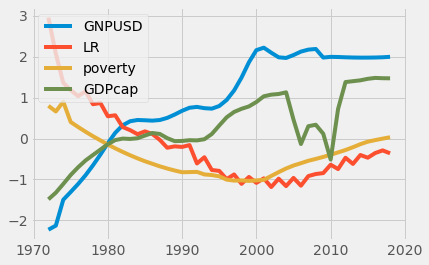

In [26]:
plt.style.use('fivethirtyeight')
ax=pd.DataFrame(20*(W1.GNPUSD)-6).plot()
W1[['LR','poverty','GDPcap']].plot(ax=ax)

In [27]:
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score


In [28]:
W1_=W1.fillna(0)

In [252]:
rf, cors, AIC, likelihoods = [], [],[],[]
FORMULA=['LR~ poverty+population+sp500+rep_senate+GNIUSD+GNPUSD+GDPcap',
         'LR~ poverty+population+sp500+GNIUSD+GNPUSD+GDPcap',
'LR~ population*poverty',
'LR~ population*GNPUSD',
'LR~ population*GDPcap',
'LR~ poverty+GNPUSD+GDPcap',
'LR~ poverty*GDPcap',
'LR~ GDPcap',
'LR~ GNIUSD',
'LR~ GNIUSD*poverty',
'LR~ GNPUSD',
'LR~ poverty',
'LR~ poverty*GNPUSD',
'LR~ rep_congress',
'LR~ rep_congress*GNPUSD']

for index in np.arange(len(FORMULA)):
    model = smf.glm(
        formula=FORMULA[index],
        data=W1_,
        family=sm.families.Gaussian(sm.families.links.log())
    ).fit(method='bfgs',maxiter=1000)

    AIC.append(model.aic)
    likelihoods.append(model.llf)

    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': W1_.LR.values}, 
        index=W1_.index).corr().loc['prd', 'grd']
    cors.append(cor)
    rf.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

In [254]:
RF=pd.DataFrame({'cors':cors,'aic':AIC,'llk':likelihoods},index=FORMULA).sort_values('llk')
INDEX=pd.Series(RF.aic<110).values

RF=RF[INDEX]
RF

,cors,aic,llk
LR~ poverty,0.722296,108.228299,-52.114150
LR~ GDPcap,0.737886,107.410429,-51.705214
LR~ GNIUSD,0.755456,106.173453,-51.086726
LR~ GNPUSD,0.782629,104.747514,-50.373757
LR~ population*poverty,0.778389,108.317074,-50.158537
LR~ poverty+GNPUSD+GDPcap,0.787559,107.176885,-49.588442
LR~ rep_congress*GNPUSD,0.827417,106.939317,-49.469659
LR~ poverty*GDPcap,0.794900,106.232072,-49.116036
LR~ GNIUSD*poverty,0.802120,106.058457,-49.029229
LR~ poverty*GNPUSD,0.820824,104.893600,-48.446800


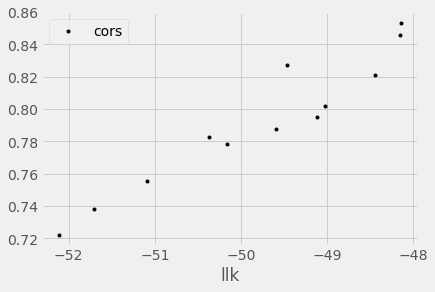

In [255]:
RF.plot(x='llk',y='cors',style='k.')

In [270]:
rf_=[rf[i] for i in np.arange(len(FORMULA)) if INDEX[i]]
FORMULA_= [FORMULA[i] for i in np.arange(len(FORMULA)) if INDEX[i]]
count=0
for i in rf_:
    if (i['P>|z|'].abs() < 0.05).any():
        print(FORMULA_[count])
        display(i)
    count=count+1

LR~ population*GDPcap


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.6992,0.705,-2.411,0.016,-3.081,-0.318
population,-3.6949,2.122,-1.741,0.082,-7.854,0.464
GDPcap,-1.6905,1.254,-1.348,0.178,-4.149,0.768
population:GDPcap,-2.3965,2.558,-0.937,0.349,-7.410,2.617


LR~ GDPcap


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-2.4272,0.727,-3.341,0.001,-3.851,-1.003
GDPcap,-2.3437,0.522,-4.488,0.000,-3.367,-1.320


LR~ GNIUSD


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.5472,0.576,-2.687,0.007,-2.676,-0.419
GNIUSD,-7.2848,1.777,-4.099,0.000,-10.768,-3.802


LR~ GNPUSD


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,5.4705,1.005,5.445,0.0,3.501,7.440
GNPUSD,-23.8111,4.902,-4.857,0.0,-33.419,-14.203


LR~ poverty


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.7521,0.607,-2.888,0.004,-2.941,-0.563
poverty,3.0659,0.716,4.281,0.000,1.662,4.470


LR~ poverty*GNPUSD


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,4.5303,2.477,1.829,0.067,-0.324,9.385
poverty,-3.2041,3.185,-1.006,0.314,-9.446,3.038
GNPUSD,-19.4425,9.196,-2.114,0.034,-37.467,-1.419
poverty:GNPUSD,16.7694,12.725,1.318,0.188,-8.171,41.710


LR~ rep_congress


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-2.9654,1.293,-2.294,0.022,-5.499,-0.432
rep_congress,-1.7122,0.843,-2.032,0.042,-3.364,-0.061


LR~ rep_congress*GNPUSD


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,6.1564,1.858,3.313,0.001,2.514,9.799
rep_congress,2.2537,3.241,0.695,0.487,-4.098,8.605
GNPUSD,-26.8989,8.552,-3.145,0.002,-43.660,-10.137
rep_congress:GNPUSD,-10.1429,12.904,-0.786,0.432,-35.434,15.148


<AxesSubplot:>

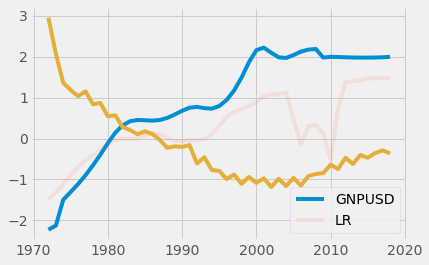

In [32]:
plt.style.use('fivethirtyeight')
ax=pd.DataFrame(20*(W1.GNPUSD)-6).plot()
W1.GDPcap.plot(ax=ax,alpha=.1)
W1[['LR']].plot(ax=ax)

# GNP vs GDP
Gross domestic product (GDP) is the value of a nation's finished domestic goods and services during a specific time period. A related but different metric, the gross national product (GNP), is the value of all finished goods and services owned by a country's residents over a period of time.

---

## GNP "explains" Polar distance over time

Note that GDPcap, GNI are also good predictors, but GNP is the best predictor that produces low enough llk and 
statistically significant coefficients

> Most importantly this underlines the observation that as economic condition improves, the ideological divide between opinion poles falls.

> Relates economic condition to ideological opinions

## Null Hypothesis: Granger Test

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.



In [33]:
data=W1[['LR','GNPUSD']]
grangercausalitytests(data, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1560  , p=0.6949  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=0.1668  , p=0.6829  , df=1
likelihood ratio test: chi2=0.1665  , p=0.6832  , df=1
parameter F test:         F=0.1560  , p=0.6949  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9089  , p=0.4111  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=2.0451  , p=0.3597  , df=2
likelihood ratio test: chi2=2.0000  , p=0.3679  , df=2
parameter F test:         F=0.9089  , p=0.4111  , df_denom=40, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8020  , p=0.1638  , df_denom=37, df_num=3
ssr based chi2 test:   chi2=6.4287  , p=0.0925  , df=3
likelihood ratio test: chi2=6.0003  , p=0.1116  , df=3
parameter F test:         F=1.8020  , p=0.1638  , df_denom=37, df_num=3


{1: ({'ssr_ftest': (0.15595876828805458, 0.6948569685741686, 43.0, 1),
   'ssr_chi2test': (0.1668396125872212, 0.6829359545074591, 1),
   'lrtest': (0.1665377828729504, 0.683207300268008, 1),
   'params_ftest': (0.1559587682880466, 0.6948569685741774, 43.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9089343078974575, 0.41111370082171483, 40.0, 2),
   'ssr_chi2test': (2.045102192769279, 0.3596762001203673, 2),
   'lrtest': (1.9999922814220952, 0.3678808609272452, 2),
   'params_ftest': (0.9089343078974299, 0.41111370082172527, 40.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.8019811866883504, 0.16375163527055375, 37.0, 3),
   'ssr_chi2test': (6.4286896389962775, 0.09251763244472333, 3),
   'lrtest': (6.000307195214106, 0.11159528033638333, 3),
   'params_ftest': (1.8019811866883613, 0.16375163527055125, 37.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

In [34]:
data=W1[['GNPUSD','LR']]
grangercausalitytests(data, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1512  , p=0.0830  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=3.3710  , p=0.0664  , df=1
likelihood ratio test: chi2=3.2532  , p=0.0713  , df=1
parameter F test:         F=3.1512  , p=0.0830  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5539  , p=0.5790  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=1.2463  , p=0.5363  , df=2
likelihood ratio test: chi2=1.2293  , p=0.5408  , df=2
parameter F test:         F=0.5539  , p=0.5790  , df_denom=40, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.5154  , p=0.0031  , df_denom=37, df_num=3
ssr based chi2 test:   chi2=19.6764 , p=0.0002  , df=3
likelihood ratio test: chi2=16.2635 , p=0.0010  , df=3
parameter F test:         F=5.5154  , p=0.0031  , df_denom=37, df_num=3


{1: ({'ssr_ftest': (3.1511562646607016, 0.08295180736656357, 43.0, 1),
   'ssr_chi2test': (3.371004376148658, 0.06635329174467915, 1),
   'lrtest': (3.2532073737935434, 0.07128384206214905, 1),
   'params_ftest': (3.1511562646605022, 0.08295180736657294, 43.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.553908989678217, 0.5790436848311705, 40.0, 2),
   'ssr_chi2test': (1.2462952267759884, 0.5362538585213468, 2),
   'lrtest': (1.2293490498677215, 0.5408168890797134, 2),
   'params_ftest': (0.5539089896782632, 0.5790436848311453, 40.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.51535425053752, 0.0031119675373226436, 37.0, 3),
   'ssr_chi2test': (19.676398947863582, 0.00019807497605935182, 3),
   'lrtest': (16.263471700667026, 0.001001307022064118, 3),
   'params_ftest': (5.515354250537819, 0.0031119675373217207, 37.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

In [35]:
data=W1[['LR','poverty']]
grangercausalitytests(data, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9584  , p=0.0116  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=7.4439  , p=0.0064  , df=1
likelihood ratio test: chi2=6.8996  , p=0.0086  , df=1
parameter F test:         F=6.9584  , p=0.0116  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9166  , p=0.0123  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=11.0624 , p=0.0040  , df=2
likelihood ratio test: chi2=9.8911  , p=0.0071  , df=2
parameter F test:         F=4.9166  , p=0.0123  , df_denom=40, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.9367  , p=0.0003  , df_denom=37, df_num=3
ssr based chi2 test:   chi2=28.3149 , p=0.0000  , df=3
likelihood ratio test: chi2=21.8610 , p=0.0001  , df=3
parameter F test:         F=7.9367  , p=0.0003  , df_denom=37, df_num=3


{1: ({'ssr_ftest': (6.958415896220846, 0.011567453411402317, 43.0, 1),
   'ssr_chi2test': (7.4438867727013704, 0.0063652277501659036, 1),
   'lrtest': (6.899579634500981, 0.008621601937872786, 1),
   'params_ftest': (6.958415896220865, 0.011567453411402246, 43.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.916628960302146, 0.01232577433111639, 40.0, 2),
   'ssr_chi2test': (11.062415160679828, 0.003961202729177473, 2),
   'lrtest': (9.891141153688778, 0.007114853934789378, 2),
   'params_ftest': (4.91662896030212, 0.01232577433111663, 40.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.936738941507456, 0.0003278264794438858, 37.0, 3),
   'ssr_chi2test': (28.314852439972544, 3.119267096901746e-06, 3),
   'lrtest': (21.860955691862813, 6.972399223629024e-05, 3),
   'params_ftest': (7.936738941507535, 0.0003278264794438635, 37.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [